# Graph Neural Nets for Molecular Property Prediction
> Building a graphical neural net regressor to predict molecular properties from chemical structures.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

# Background and Intuition

## VantAI Prediction Challenge, 2021

"The goal of this Challenge is to predict lipophilicity, which is the ability of a chemical compound to dissolve in fats. Given that lipophilicity plays a key role in drug uptake and metabolism, it is an important physiochemical parameter for which prediction based on chemical structure could have a significant impact on drug discovery programs. Lipophilicity prediction is also a common task in machine learning prediction challenges."

In other words, we are to learn a function $f(x) = y$ where $x$ is the SMILES representation of a given chemical structure, and $y$ is the $\log d$ value of lipophilicity of the molecule.

*Unless otherwise noted, such as in the case of open-source packages, I certify that all work is entirely my own.*

Simon Levine-Gottreich

M.S. Computational Biology ,'21

Carnegie Mellon University

## Graph Neural Nets

Per literature, GNNs seem to outperform classical statistical learning methods on benchmark molecular structure. Though some controversy exists about generalizability, I will proceed with A GNN. First, I will built a dataloader using `pytorch-geometric` and train and evaluate a simple GCN per the package tutorial. This should give a good baseline.

I will proceed to then use a more complex graph neural net framework via Principal Neighbourhood Aggregation (`arxiv.org/abs/2004.05718`).

Finally, in the interest of the *competition* (this is sometimes a no-no when data is limited and specific), I will augment the existing dataset with a second $SMILES \to \log d_{\text{lipophilicity}}$ Stanford's MoleculeNet Lipophilicity regression (http://moleculenet.ai/datasets-1) dataset.

I will ensure that any common SMILES structures are eliminated from this augmented dataframe. Ideally, this will allow for the model to better generalize to the test set, as it was described by the challenge authors as 

# EDA, Preprocessing, and Augmentation

I will begin with some exploratory analysis of the dataset as well as show how conversion from SMILES to a graph object will occur under the hood.

In [75]:
import pandas as pd

train_df = pd.read_csv('train/raw/60170fff5b630f3433c202be_train.csv')
test_df = pd.read_csv('test/raw/60170fffa2720fa4d0b9067a_holdout_set.csv')
eval_df = pd.read_csv('alt/raw/Lipophilicity.csv', usecols=['exp','smiles']).rename(columns={'smiles':'Smiles','exp': 'label'})

train_df

,Smiles,label
0,CC(C)Oc1cc(Oc2ccc(S(C)(=O)=O)cc2)cc(-c2ncc(Cl)...,2.00
1,CNS(=O)(=O)c1ccc(Oc2cc(OC(C)C)cc(-c3nccc(=O)[n...,2.60
2,CC(C)Oc1cc(Oc2cnc(C(=O)N(C)C)c(F)c2)cc(-c2nccc...,1.50
3,CC(C)Oc1cc(Oc2cnc(C(=O)N(C)C)cn2)cc(-c2nccc(=O...,1.30
4,CCC(CC)Oc1cc(Oc2cnc(C(=O)N(C)C)nc2)cc(-c2nccc(...,1.90
...,...,...
3824,CCC(C)C(N)C(=O)NC(C(=O)NCC(=O)NC(Cc1ccccc1)C(=...,-0.99
3825,CCC(C)C(N)C(=O)NC(C)C(=O)NC(C)C(=O)NC(C(=O)O)C...,-2.82
3826,NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)NCC(=O)NC(...,0.17
3827,CC(C)CC(NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(N)C(C)C...,-1.23


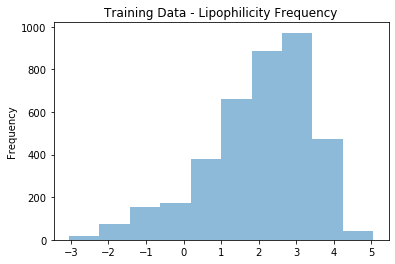

In [63]:
train_df['label'].plot.hist(title='Training Data - Lipophilicity Frequency',alpha=0.50)

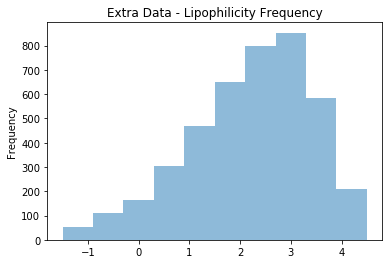

In [79]:
eval_df['label'].plot.hist(title='Extra Data - Lipophilicity Frequency',alpha=0.50) #note column names differ...

Interesting! We see a quasi-Guassian pattern in these continuous labels.
I'll now convert the representations from SMILES to the graphical scruture needed (note the dataloader to come will do this automatically.)

But first, I'd like to check on the data quality. Are there any identical SMILES?

In [145]:
sum(train_df['Smiles'].value_counts()!=1)

26

Yes! 26. I won't filter this yet but I'll keep it in mind.

Anyway, onto converting the SMILES to graphs!

In [80]:
import rdkit
from tqdm.notebook import trange, tqdm
from ogb.utils import smiles2graph

tqdm.pandas('Converting SMILES to molecular graph...')
train_df['graph'] = train_df.progress_apply(lambda row: smiles2graph(row['Smiles']),axis=1)

In [82]:
test_df['graph']=test_df.progress_apply(lambda row: smiles2graph(row['Smiles']),axis=1)
eval_df['graph']=eval_df.progress_apply(lambda row: smiles2graph(row['Smiles']),axis=1)

In [83]:
row = train_df.sample(1)
row

,Smiles,label,graph
1027,COc1ccc(NC(=O)c2ccc(-c3ccncc3)c(C)c2)cc1N1CCN(...,2.56,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."


In [95]:
print(row['graph'].values[0])

{'edge_index': array([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
         7,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16,
        16, 17, 17, 18, 12, 19, 19, 20, 19, 21,  5, 22, 22, 23, 23, 24,
        24, 25, 25, 26, 26, 27, 27, 28, 27, 29, 29, 30, 23,  2, 30, 24,
        21,  9, 18, 13],
       [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,
         9,  7, 10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15,
        17, 16, 18, 17, 19, 12, 20, 19, 21, 19, 22,  5, 23, 22, 24, 23,
        25, 24, 26, 25, 27, 26, 28, 27, 29, 27, 30, 29,  2, 23, 24, 30,
         9, 21, 13, 18]]), 'edge_feat': array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [3, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [3, 0, 1],
  

I'll actually begin by processing and saving the combined train and extra valid dataframes for possible use later as a "new" csv...

In [128]:
eval_df=eval_df[train_df.columns] #reordering columns to match training...
eval_df

,Smiles,label,graph
0,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
1,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
2,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69,"{'edge_index': [[0, 1, 1, 2, 2, 3, 2, 4, 4, 5,..."
3,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37,"{'edge_index': [[0, 1, 1, 2, 2, 3, 2, 4, 4, 5,..."
4,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
...,...,...,...
4195,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1,3.85,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4196,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...,3.21,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4197,COc1cccc2[nH]ncc12,2.10,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4198,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3,2.65,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."


In [144]:
sum(train_df['Smiles'].value_counts()!=1)

26

Remember this? Well, now I should make sure the final augmented training dataset has no duplicates and absolutely NO overlap with the train set (and the test set for that matter...)

In [125]:
augmented_train_df = pd.concat([train_df,eval_df])
augmented_train_df

,Smiles,label,graph
0,CC(C)Oc1cc(Oc2ccc(S(C)(=O)=O)cc2)cc(-c2ncc(Cl)...,2.00,"{'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4, 5,..."
1,CNS(=O)(=O)c1ccc(Oc2cc(OC(C)C)cc(-c3nccc(=O)[n...,2.60,"{'edge_index': [[0, 1, 1, 2, 2, 3, 2, 4, 2, 5,..."
2,CC(C)Oc1cc(Oc2cnc(C(=O)N(C)C)c(F)c2)cc(-c2nccc...,1.50,"{'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4, 5,..."
3,CC(C)Oc1cc(Oc2cnc(C(=O)N(C)C)cn2)cc(-c2nccc(=O...,1.30,"{'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4, 5,..."
4,CCC(CC)Oc1cc(Oc2cnc(C(=O)N(C)C)nc2)cc(-c2nccc(...,1.90,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 2, 5,..."
...,...,...,...
4195,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1,3.85,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4196,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...,3.21,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4197,COc1cccc2[nH]ncc12,2.10,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4198,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3,2.65,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."


In [127]:
#checking if Smiles values match, then drop those duplicates
len(augmented_train_df[augmented_train_df.duplicated(['Smiles'],keep=False)])

618

Apparently many of the VantAI SMILES fingerprints match. I'll drop these duplicate since we don't want to overfit. I'll quickly check after for any overlap with the test set.

In [123]:
augmented_train_df = augmented_train_df.drop_duplicates(['Smiles'])
augmented_train_df

,Smiles,label,graph
0,CC(C)Oc1cc(Oc2ccc(S(C)(=O)=O)cc2)cc(-c2ncc(Cl)...,2.00,"{'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4, 5,..."
1,CNS(=O)(=O)c1ccc(Oc2cc(OC(C)C)cc(-c3nccc(=O)[n...,2.60,"{'edge_index': [[0, 1, 1, 2, 2, 3, 2, 4, 2, 5,..."
2,CC(C)Oc1cc(Oc2cnc(C(=O)N(C)C)c(F)c2)cc(-c2nccc...,1.50,"{'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4, 5,..."
3,CC(C)Oc1cc(Oc2cnc(C(=O)N(C)C)cn2)cc(-c2nccc(=O...,1.30,"{'edge_index': [[0, 1, 1, 2, 1, 3, 3, 4, 4, 5,..."
4,CCC(CC)Oc1cc(Oc2cnc(C(=O)N(C)C)nc2)cc(-c2nccc(...,1.90,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 2, 5,..."
...,...,...,...
4194,CC1CC(N(C(=O)C)c2ccccc2)c3ccccc3N1S(=O)(=O)c4c...,3.68,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4195,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1,3.85,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4196,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...,3.21,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4198,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3,2.65,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."


In [146]:
sum(test_df['Smiles'].isin(eval_df['Smiles']).astype(int))

0

Phew! No overlap. The test set is good to go!

Now, saving the big augmented dataframe as a CSV (minus the `graph` column; my `Geometric` dataloader will do this for free) as this will be used as a final "training" dataset (augmented for maximum performance) on the final model. I will also quickly save the Stanford CSV again but without any SMILES common to the VantAI training set. This will provide an evaluation dataset for model iteration without compromising the (somewhat limited) training set.

In [171]:
augmented_train_df.drop(columns=['graph']).to_csv('./train_augmented/raw/train_augmented.csv',index=False)

In [149]:
eval_df['Smiles'].isin(train_df['Smiles']).astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
4195    0
4196    0
4197    1
4198    0
4199    0
Name: Smiles, Length: 4200, dtype: int64

In [152]:
eval_df_filtered = eval_df[~eval_df['Smiles'].isin(train_df['Smiles'])]
eval_df_filtered

,Smiles,label,graph
0,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
1,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
2,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69,"{'edge_index': [[0, 1, 1, 2, 2, 3, 2, 4, 4, 5,..."
3,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37,"{'edge_index': [[0, 1, 1, 2, 2, 3, 2, 4, 4, 5,..."
4,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
...,...,...,...
4194,CC1CC(N(C(=O)C)c2ccccc2)c3ccccc3N1S(=O)(=O)c4c...,3.68,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4195,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1,3.85,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4196,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...,3.21,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."
4198,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3,2.65,"{'edge_index': [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5,..."


In [172]:
eval_df_filtered.drop(columns=['graph']).to_csv('./eval/raw/Lipophilicity_filtered.csv',index=False)

# Machine Learning

## Data

I'll begin by using `Pytorch-Geometric`'s MoleculeNet inherited dataset class. Credit for this object to Pytorch Geometric!

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

In [227]:
import os
import os.path as osp
import re

import torch
from torch_geometric.data import (InMemoryDataset, Data, download_url,
                                  extract_gz)

try:
    from rdkit import Chem
except ImportError:
    Chem = None

x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

e_map = {
    'bond_type': [
        'misc',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'is_conjugated': [False, True],
}


class MoleculeNet(InMemoryDataset):
    r"""The `MoleculeNet <http://moleculenet.ai/datasets-1>`_ benchmark
    collection  from the `"MoleculeNet: A Benchmark for Molecular Machine
    Learning" <https://arxiv.org/abs/1703.00564>`_ paper, containing datasets
    from physical chemistry, biophysics and physiology.
    All datasets come with the additional node and edge features introduced by
    the `Open Graph Benchmark <https://ogb.stanford.edu/docs/graphprop/>`_.

    Args:
        root (string): Root directory where the dataset should be saved.
        name (string): The name of the dataset (:obj:`"ESOL"`,
            :obj:`"FreeSolv"`, :obj:`"Lipo"`, :obj:`"PCBA"`, :obj:`"MUV"`,
            :obj:`"HIV"`, :obj:`"BACE"`, :obj:`"BBPB"`, :obj:`"Tox21"`,
            :obj:`"ToxCast"`, :obj:`"SIDER"`, :obj:`"ClinTox"`).
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
    """

    # Format: name: [display_name, url_name, csv_name, smiles_idx, y_idx]
    names = {
        'train': ['Train', '60170fff5b630f3433c202be_train.csv', '60170fff5b630f3433c202be_train', 0, 1],
        'test':['Test','60170fffa2720fa4d0b9067a_holdout_set.csv','60170fffa2720fa4d0b9067a_holdout_set',0,1],
        'eval': ['Lipophilicity Filtered', 'Lipophilicity_filtered.csv', 'Lipophilicity_filtered', 0, 1], #stanford dataset
        'train_augmented':['Train Augmented','train_augmented.csv','train_augmented',0,1], #vantai train + stanford
    }

    def __init__(self, root, name, transform=None, pre_transform=None,
                 pre_filter=None):

        if Chem is None:
            raise ImportError('`MoleculeNet` requires `rdkit`.')

        self.name = name.lower()
        assert self.name in self.names.keys()
        super(MoleculeNet, self).__init__(root, transform, pre_transform,
                                          pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self):
        return f'{self.names[self.name][2]}.csv'

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        with open(self.raw_paths[0], 'r') as f:
            # dataset = f.read().split('\n')[1:-1]

            dataset = f.read().split('\n')[1:] #issue w/ test loader
            dataset = [x for x in dataset if len(x) > 0]  # Filter empty lines.

        data_list = []
        for line in dataset:
            line = re.sub(r'\".*\"', '', line)  # Replace ".*" strings.
            line = line.split(',')

            smiles = line[self.names[self.name][3]]
            ys = line[self.names[self.name][4]]
            ys = ys if isinstance(ys, list) else [ys]

            ys = [float(y) if len(y) > 0 else float('NaN') for y in ys]
            y = torch.tensor(ys, dtype=torch.float).view(1, -1)

            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue

            xs = []
            for atom in mol.GetAtoms():
                x = []
                x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
                x.append(x_map['chirality'].index(str(atom.GetChiralTag())))
                x.append(x_map['degree'].index(atom.GetTotalDegree()))
                x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
                x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
                x.append(x_map['num_radical_electrons'].index(
                    atom.GetNumRadicalElectrons()))
                x.append(x_map['hybridization'].index(
                    str(atom.GetHybridization())))
                x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
                x.append(x_map['is_in_ring'].index(atom.IsInRing()))
                xs.append(x)

            x = torch.tensor(xs, dtype=torch.long).view(-1, 9)

            edge_indices, edge_attrs = [], []
            for bond in mol.GetBonds():
                i = bond.GetBeginAtomIdx()
                j = bond.GetEndAtomIdx()

                e = []
                e.append(e_map['bond_type'].index(str(bond.GetBondType())))
                e.append(e_map['stereo'].index(str(bond.GetStereo())))
                e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

                edge_indices += [[i, j], [j, i]]
                edge_attrs += [e, e]

            edge_index = torch.tensor(edge_indices)
            edge_index = edge_index.t().to(torch.long).view(2, -1)
            edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

            # Sort indices.
            if edge_index.numel() > 0:
                perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
                edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,
                        smiles=smiles)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            data_list.append(data)

        torch.save(self.collate(data_list), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.names[self.name][0], len(self))


## Datasets

Now we have a dataset class that handles the CSVs and converts to a graphical object, as desired. The next step is to pull the CSVs. Note I will use the extra Stanford MoleculeNet mol-lipo dataset (filtered for VantAI overlap...) as an evaluation set.

In [174]:
train_dataset=MoleculeNet(root='./',name='train')
train_dataset.process()

test_dataset=MoleculeNet(root='./',name='test')
test_dataset.process()

eval_dataset=MoleculeNet(root='./',name='eval')
eval_dataset.process()

Processing...
Done!


In [231]:
test_dataset

Test(141)

In [175]:
print()
print(f'Dataset: {train_dataset}:')
print('====================')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')

data = train_dataset[420]  # Get the a sample graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Train(3828):
Number of graphs: 3828
Number of features: 9
Number of classes: 1

Data(edge_attr=[80, 3], edge_index=[2, 80], smiles="Cc1c(Cl)ccc(OC2CCN(C3CCN(C(=O)NS(=O)(=O)c4ccc(N(C)C)cc4)CC3)CC2)c1Cl", x=[37, 9], y=[1, 1])
Number of nodes: 37
Number of edges: 80
Average node degree: 2.16
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [176]:
torch.manual_seed(12345)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of eval graphs: {len(eval_dataset)}')

Number of training graphs: 3828
Number of test graphs: 140
Number of eval graphs: 3915


That looks good!


# Basic GCN:

In [177]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)


for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
Batch(batch=[1683], edge_attr=[3618, 3], edge_index=[2, 3618], smiles=[64], x=[1683, 9], y=[64, 1])

Step 2:
Number of graphs in the current batch: 64
Batch(batch=[1812], edge_attr=[3930, 3], edge_index=[2, 3930], smiles=[64], x=[1812, 9], y=[64, 1])

Step 3:
Number of graphs in the current batch: 64
Batch(batch=[1665], edge_attr=[3620, 3], edge_index=[2, 3620], smiles=[64], x=[1665, 9], y=[64, 1])

Step 4:
Number of graphs in the current batch: 64
Batch(batch=[1759], edge_attr=[3802, 3], edge_index=[2, 3802], smiles=[64], x=[1759, 9], y=[64, 1])

Step 5:
Number of graphs in the current batch: 64
Batch(batch=[1711], edge_attr=[3702, 3], edge_index=[2, 3702], smiles=[64], x=[1711, 9], y=[64, 1])

Step 6:
Number of graphs in the current batch: 64
Batch(batch=[1708], edge_attr=[3704, 3], edge_index=[2, 3704], smiles=[64], x=[1708, 9], y=[64, 1])

Step 7:
Number of graphs in the current batch: 64
Batch(batch=[1676], edge_attr=[3632, 3], edg

In [181]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.emb = AtomEncoder(train_dataset.num_node_features)
        self.conv1 = GCNConv(train_dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.emb(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)


model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.L1Loss()

def train():
    model.train()

    loss_sum = 0

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss (Mean Absolute Error)
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         loss_sum+=loss

    return loss #loss_sum / len(train_loader.dataset)  # Derive average loss over minibatch.

        
def test(loader):
    model.eval()
    loss_sum = 0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out,data.y)
    return loss #final loss, not averaged





GCN(
  (emb): AtomEncoder(
    (embeddings): ModuleList(
      (0): Embedding(100, 9)
      (1): Embedding(100, 9)
      (2): Embedding(100, 9)
      (3): Embedding(100, 9)
      (4): Embedding(100, 9)
      (5): Embedding(100, 9)
      (6): Embedding(100, 9)
      (7): Embedding(100, 9)
      (8): Embedding(100, 9)
    )
  )
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [182]:
for epoch in range(1, 21):
    train()
    train_loss = test(train_loader)
    test_loss = test(eval_loader)
    print(f'Epoch: {epoch:03d}, Train MAE: {train_loss:.4f}, Eval MAE: {test_loss:.4f}')

Epoch: 001, Train MAE: 0.8141, Eval MAE: 0.8941
Epoch: 002, Train MAE: 0.7051, Eval MAE: 0.9485
Epoch: 003, Train MAE: 0.9569, Eval MAE: 0.9822
Epoch: 004, Train MAE: 1.0505, Eval MAE: 0.9541
Epoch: 005, Train MAE: 0.8054, Eval MAE: 0.7166
Epoch: 006, Train MAE: 0.9615, Eval MAE: 0.8790
Epoch: 007, Train MAE: 0.7860, Eval MAE: 0.8597
Epoch: 008, Train MAE: 0.8864, Eval MAE: 0.6617
Epoch: 009, Train MAE: 0.7309, Eval MAE: 0.7956
Epoch: 010, Train MAE: 0.7744, Eval MAE: 0.7239
Epoch: 011, Train MAE: 0.5969, Eval MAE: 0.7038
Epoch: 012, Train MAE: 0.8718, Eval MAE: 0.7157
Epoch: 013, Train MAE: 0.5916, Eval MAE: 0.7652
Epoch: 014, Train MAE: 0.6704, Eval MAE: 0.7045
Epoch: 015, Train MAE: 0.7025, Eval MAE: 0.6639
Epoch: 016, Train MAE: 0.7971, Eval MAE: 0.8985
Epoch: 017, Train MAE: 0.5322, Eval MAE: 0.6610
Epoch: 018, Train MAE: 0.8521, Eval MAE: 0.6547
Epoch: 019, Train MAE: 0.6657, Eval MAE: 0.7317
Epoch: 020, Train MAE: 0.7162, Eval MAE: 0.7053


Now, we have a baseline model training (and learning...something). I won't waste time on this model because I know other architectures will outperform this basic one per literature. I will also use the augmented dataset for this training/testing round, and then predict on the test CSV for submission.

## PNA

As I mentioned in the intro, Principal Neighborhood Aggregation was shown on the seperate ZINC chemical dataset to be far better performing than other graph-regressors. I will use the implementation from https://github.com/lukecavabarrett/pna going forward.

In [232]:
augmented_dataset = MoleculeNet(root='./',name='train_augmented')
augmented_dataset.process()

test_dataset = MoleculeNet(root='./',name='test')
test_dataset.process()

In [233]:
test_dataset

Test(141)

In [235]:
len(test_dataset) == len(test_df)

True

In [236]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

 in the current batch: 32
Batch(batch=[862], edge_attr=[1868, 3], edge_index=[2, 1868], smiles=[32], x=[862, 9], y=[32, 1])

Step 127:
Number of graphs in the current batch: 32
Batch(batch=[911], edge_attr=[1980, 3], edge_index=[2, 1980], smiles=[32], x=[911, 9], y=[32, 1])

Step 128:
Number of graphs in the current batch: 32
Batch(batch=[866], edge_attr=[1878, 3], edge_index=[2, 1878], smiles=[32], x=[866, 9], y=[32, 1])

Step 129:
Number of graphs in the current batch: 32
Batch(batch=[912], edge_attr=[1978, 3], edge_index=[2, 1978], smiles=[32], x=[912, 9], y=[32, 1])

Step 130:
Number of graphs in the current batch: 32
Batch(batch=[802], edge_attr=[1746, 3], edge_index=[2, 1746], smiles=[32], x=[802, 9], y=[32, 1])

Step 131:
Number of graphs in the current batch: 32
Batch(batch=[841], edge_attr=[1816, 3], edge_index=[2, 1816], smiles=[32], x=[841, 9], y=[32, 1])

Step 132:
Number of graphs in the current batch: 32
Batch(batch=[863], edge_attr=[1876, 3], edge_index=[2, 1876], smiles

# Final Training

Augmented dataset. Best model. Here goes nothing!

In [237]:
test_dataset #same as before!

Test(141)

In [238]:
test_dataset[0].y #note: No y!

tensor([[nan]])

In [265]:
import torch
import torch.nn.functional as F
from torch.nn import ModuleList
from torch.nn import Sequential, ReLU, Linear
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.utils import degree
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import AtomEncoder
from torch_geometric.data import DataLoader
from torch_geometric.nn import BatchNorm, global_mean_pool

from models.pytorch_geometric.pna import PNAConvSimple

# Compute in-degree histogram over training data.

deg = torch.zeros(10, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.node_emb = AtomEncoder(emb_dim=70)

        aggregators = ['mean', 'min', 'max', 'std']
        scalers = ['identity', 'amplification', 'attenuation']

        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        for _ in range(4):
            conv = PNAConvSimple(in_channels=70, out_channels=70, aggregators=aggregators,
                                 scalers=scalers, deg=deg, post_layers=1)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(70))

        self.mlp = Sequential(Linear(70, 35), ReLU(), Linear(35, 17), ReLU(), Linear(17, 1))

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.node_emb(x)

        for conv, batch_norm in zip(self.convs, self.batch_norms):
            h = F.relu(batch_norm(conv(x, edge_index, edge_attr)))
            x = h + x  # residual#
            x = F.dropout(x, 0.3, training=self.training)

        x = global_mean_pool(x, batch)
        return self.mlp(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=20, min_lr=0.0001)


def train(epoch):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, None, data.batch)

        loss = torch.nn.L1Loss()(out.to(torch.float32), data.y.to(torch.float32))
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [266]:
for epoch in range(1, 201):
    loss = train(epoch) #MAE
    print(f'Epoch: {epoch:02d}, MAE Loss: {loss:.4f}')

Epoch: 01, MAE Loss: 0.9188
Epoch: 02, MAE Loss: 0.7788
Epoch: 03, MAE Loss: 0.7311
Epoch: 04, MAE Loss: 0.7065
Epoch: 05, MAE Loss: 0.6833
Epoch: 06, MAE Loss: 0.6653
Epoch: 07, MAE Loss: 0.6468
Epoch: 08, MAE Loss: 0.6503
Epoch: 09, MAE Loss: 0.6535
Epoch: 10, MAE Loss: 0.6401
Epoch: 11, MAE Loss: 0.6174
Epoch: 12, MAE Loss: 0.6173
Epoch: 13, MAE Loss: 0.6049
Epoch: 14, MAE Loss: 0.6101
Epoch: 15, MAE Loss: 0.5900
Epoch: 16, MAE Loss: 0.6102
Epoch: 17, MAE Loss: 0.5972
Epoch: 18, MAE Loss: 0.5914
Epoch: 19, MAE Loss: 0.5915
Epoch: 20, MAE Loss: 0.5790
Epoch: 21, MAE Loss: 0.5827
Epoch: 22, MAE Loss: 0.5725
Epoch: 23, MAE Loss: 0.5564
Epoch: 24, MAE Loss: 0.5542
Epoch: 25, MAE Loss: 0.5508
Epoch: 26, MAE Loss: 0.5416
Epoch: 27, MAE Loss: 0.5421
Epoch: 28, MAE Loss: 0.5392
Epoch: 29, MAE Loss: 0.5386
Epoch: 30, MAE Loss: 0.5344
Epoch: 31, MAE Loss: 0.5385
Epoch: 32, MAE Loss: 0.5304
Epoch: 33, MAE Loss: 0.5305
Epoch: 34, MAE Loss: 0.5361
Epoch: 35, MAE Loss: 0.5313
Epoch: 36, MAE Loss:

In [267]:
out = [float(model(data.x, data.edge_index, None, data.batch).cpu().detach().numpy().squeeze()) for data in test_loader]
out

[2.1378262042999268,
 2.275381088256836,
 2.30702805519104,
 2.759007215499878,
 2.073575496673584,
 2.151681423187256,
 2.0823657512664795,
 2.3716416358947754,
 2.5554802417755127,
 2.118537187576294,
 2.52313494682312,
 2.3890836238861084,
 2.010721206665039,
 2.375124454498291,
 2.399320602416992,
 2.5365734100341797,
 2.7736339569091797,
 1.839406132698059,
 1.950378179550171,
 2.669766426086426,
 1.5200785398483276,
 2.107769012451172,
 1.8128150701522827,
 2.653503894805908,
 2.027639389038086,
 2.3419618606567383,
 2.2847790718078613,
 2.599226951599121,
 1.974503755569458,
 2.5277113914489746,
 2.207794189453125,
 2.43381667137146,
 2.118598699569702,
 2.609818696975708,
 1.8981696367263794,
 2.648371696472168,
 2.43735933303833,
 2.6339094638824463,
 2.5150341987609863,
 1.97249174118042,
 2.229358673095703,
 2.4537973403930664,
 2.4356417655944824,
 2.383260488510132,
 2.7051684856414795,
 2.077136516571045,
 2.5342206954956055,
 2.3572046756744385,
 2.612536907196045,
 2.02

In [268]:
len(out)

141

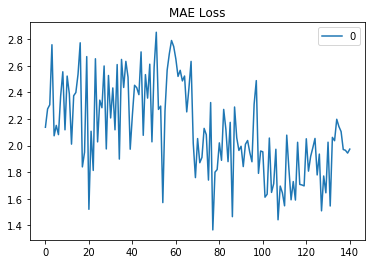

In [271]:
pd.DataFrame(out).plot(title='MAE Loss')

In [269]:
submission_df = pd.read_csv('test/raw/60170fffa2720fa4d0b9067a_holdout_set.csv')
submission_df['predicted']=out
submission_df.to_csv('submissions/60170fffa2720fa4d0b9067a_holdout_set.csv',index=False,)

# DONE! (for now...)

We are done! I will submit this final CSV for the competition. Fingers crossed. This is by no means a finished product or production-ready pipeline, and remains a work in progress.